# **Project Notebook**

This notebook contains the code work for Data Science project "Uncertainty quantification of deep neural networks for high-dimensional data" for the CS-E4875 course.

For the data I've decided to use the "Predict Student Performance from Game Play" dataset from Kaggle: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/data?select=sample_submission.csv The data aims to predict students performance for questions, given their past performance. This is a proxy task for something I currently work on in my dayjob so it should pose an interesting problem to tackle. 

Let's load the the data and explore it a bit:

In [1]:
# imports
import pandas as pd
import dask.dataframe as dd
import dask
import pyarrow.parquet as pq

from functools import partial
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn




/opt/software/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


## Model with mock data
I'll re-implement the model below, using the version from https://blog.ceshine.net/post/quantile-regression-part-2/#source-code

In [2]:
np.random.seed(100)

# ## Prepare Dataset

def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Calculate bounds
n_std = 1.645  # For approximately 90% coverage
upper_bound = f(X).ravel() + n_std * dy
lower_bound = f(X).ravel() - n_std * dy

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

X.shape, y.shape, xx.shape

((100, 1), (100,), (1000, 1))

In [3]:
class q_model(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=1,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [4]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)


# ## Train the Model

# Run training
epochs = 10000
learner.fit(X, y, epochs, batch_size=10)

Epoch 500: 1.8220107555389404
Epoch 1000: 1.605822205543518
Epoch 1500: 1.5439636707305908
Epoch 2000: 1.4003398418426514
Epoch 2500: 1.3048086166381836
Epoch 3000: 1.2806721925735474
Epoch 3500: 1.400397539138794
Epoch 4000: 1.2245038747787476
Epoch 4500: 1.2168630361557007
Epoch 5000: 1.2266404628753662
Epoch 5500: 1.286145567893982
Epoch 6000: 1.2715400457382202
Epoch 6500: 1.2806569337844849
Epoch 7000: 1.3136532306671143
Epoch 7500: 1.266616940498352
Epoch 8000: 1.224725365638733
Epoch 8500: 1.130286455154419
Epoch 9000: 1.181217908859253
Epoch 9500: 1.2685171365737915
Epoch 10000: 1.1391479969024658


In [5]:
# Make the prediction on the meshed x-axis
predicted_percentiles = learner.predict(xx) # Assuming this gives [lower, median, upper]
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

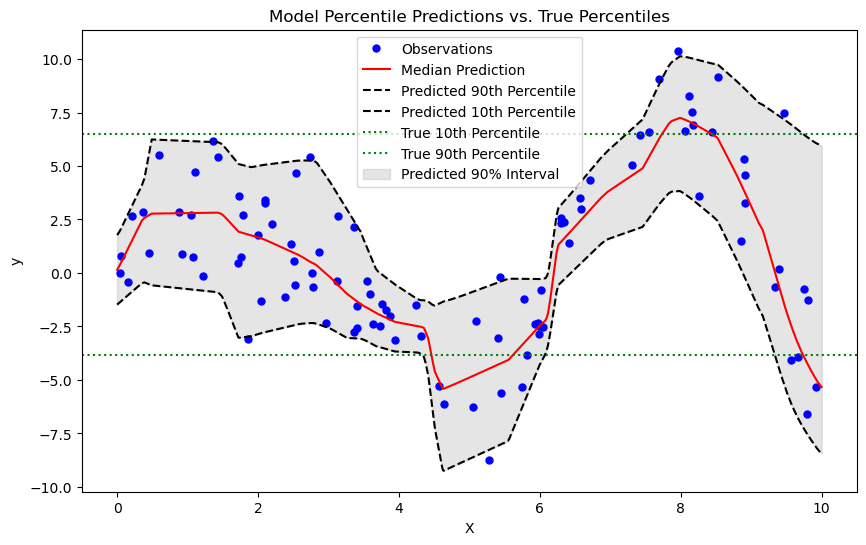

<Figure size 640x480 with 0 Axes>

In [6]:
# Plot the function, the prediction and the 90% confidence interval based on
# the MSE

# True Percentiles
y_lower_true = np.percentile(y, 10)
y_upper_true = np.percentile(y, 90)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=10, label='Observations')
plt.plot(xx, y_pred, 'r-', label='Median Prediction')
plt.plot(xx, y_upper_pred, 'k--', label='Predicted 90th Percentile')
plt.plot(xx, y_lower_pred, 'k--', label='Predicted 10th Percentile')
plt.axhline(y=y_lower_true, color='g', linestyle=':', label='True 10th Percentile')
plt.axhline(y=y_upper_true, color='g', linestyle=':', label='True 90th Percentile')
plt.fill_between(xx.ravel(), y_lower_pred, y_upper_pred, alpha=0.2, color='gray', label='Predicted 90% Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Model Percentile Predictions vs. True Percentiles')
plt.legend()
plt.show()
plt.savefig('./images/prediction_dummy_data.png')
plt.show()

Percentage in the range (expecting 90%): 92.0
Percentage out of the range (expecting 10%): 8.0


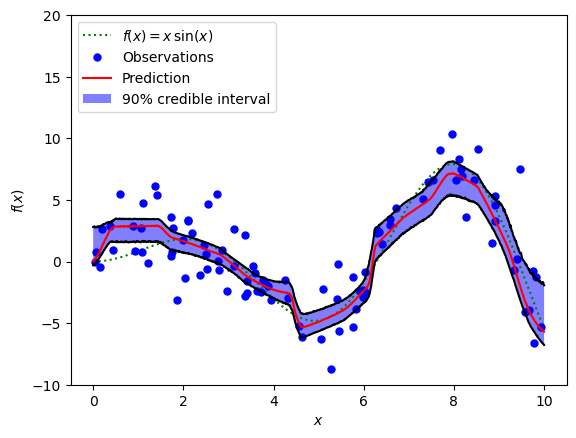

In [7]:
predictions = learner.predict(X)
np.mean(predictions[:, 0]), np.mean(predictions[:, 1]), np.mean(predictions[:, 2])


in_the_range = np.sum((y >= predictions[:, 0]) & (y <= predictions[:, 2]))
print("Percentage in the range (expecting 90%):", in_the_range / len(y) * 100)

out_of_the_range = np.sum((y < predictions[:, 0]) | (y > predictions[:, 2]))
print("Percentage out of the range (expecting 10%):", out_of_the_range / len(y)  * 100)


# ## MC Prediction

K = 5000
tmp = np.zeros((K, xx.shape[0])).astype("float32")
for k in range(K):
    preds = learner.predict(xx, mc=True)
    tmp[k] = preds[:, 1]
y_lower, y_pred, y_upper = np.percentile(tmp, (5, 50, 95), axis=0)    

y_lower[1], y_pred[1], y_upper[1]


# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% credible interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

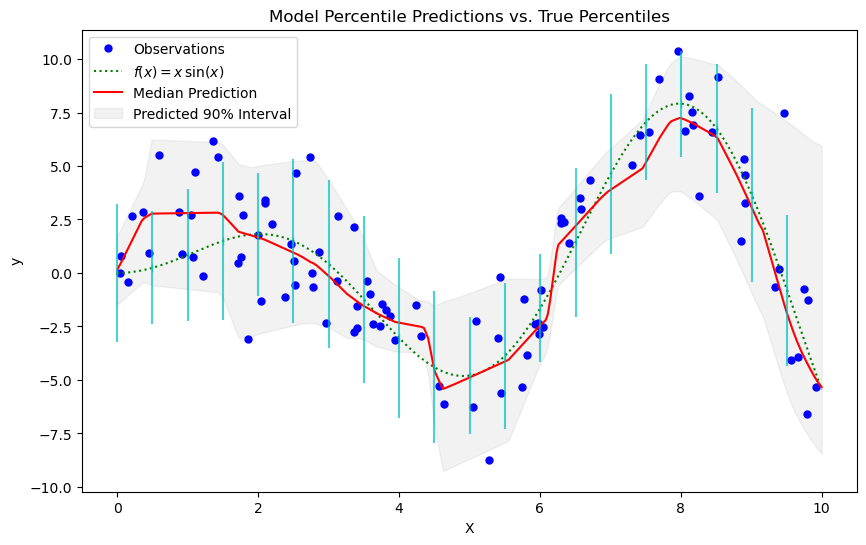

In [8]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(100)

def f(x):
    return x * np.sin(x)

# Generate data
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

# Predict percentiles using the model
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)
predicted_percentiles = learner.predict(xx) # Assuming this gives [lower, median, upper]
y_lower_pred, y_pred, y_upper_pred = predicted_percentiles[:, 0], predicted_percentiles[:, 1], predicted_percentiles[:, 2]

# Calculate dynamic true percentiles for each point in xx
dy_xx = 1.5 + 1.0 * np.random.random(xx.shape[0])  # Ensure dy_xx matches the length of xx
y_lower_true = f(xx).ravel() - 1.645 * dy_xx  # 10th percentile
y_upper_true = f(xx).ravel() + 1.645 * dy_xx  # 90th percentile

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(X, y, 'b.', markersize=10, label='Observations')
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(xx, y_pred, 'r-', label='Median Prediction')
plt.fill_between(xx.ravel(), y_lower_pred, y_upper_pred, alpha=0.1, color='gray', label='Predicted 90% Interval')

# Add vertical bars for true percentiles at regular intervals
interval = 50  # Interval for placing the vertical bars
for i in range(0, len(xx), interval):
    x_val = xx.ravel()[i]
    lower_val = y_lower_true[i]
    upper_val = y_upper_true[i]
    plt.errorbar(x_val, (lower_val + upper_val) / 2, yerr=[[(upper_val - lower_val) / 2]], fmt='c|', alpha=0.7)

plt.xlabel('X')
plt.ylabel('y')
plt.title('Model Percentile Predictions vs. True Percentiles')
plt.legend()
plt.show()


## Extend the model to use two dimensions

In [9]:
## Build the Model

class q_model_2_dimensions(nn.Module):
    def __init__(self, 
                 quantiles, 
                 in_shape=2,  
                 dropout=0.5):     
        super().__init__()
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)
        
        self.in_shape = in_shape
        self.out_shape = len(quantiles)
        self.dropout = dropout
        self.build_model()
        self.init_weights()
        
    def build_model(self): 
        self.base_model = nn.Sequential(
            nn.Linear(self.in_shape, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
            nn.Linear(64, 64),
            nn.ReLU(),
            # nn.BatchNorm1d(64),
            nn.Dropout(self.dropout),
        )
        final_layers = [
            nn.Linear(64, 1) for _ in range(len(self.quantiles))
        ]
        self.final_layers = nn.ModuleList(final_layers)
        
    def init_weights(self):
        for m in chain(self.base_model, self.final_layers):
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight)
                nn.init.constant_(m.bias, 0)        
        
    def forward(self, x):
        tmp_ = self.base_model(x)
        return torch.cat([layer(tmp_) for layer in self.final_layers], dim=1)


class QuantileLoss_2(nn.Module):
    def __init__(self, quantiles):
        super().__init__()
        self.quantiles = quantiles
        
    def forward(self, preds, target):
        assert not target.requires_grad
        assert preds.size(0) == target.size(0)
        losses = []
        for i, q in enumerate(quantiles):
            errors = target - preds[:, i]
            losses.append(torch.max((q-1) * errors, q * errors).unsqueeze(1))
        loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
        return loss


class Learner_2:
    def __init__(self, model, optimizer_class, loss_func, device='cpu'):
        self.model = model.to(device)
        self.optimizer = optimizer_class(self.model.parameters())
        self.loss_func = loss_func.to(device)
        self.device = device
        self.loss_history = []
        
    def fit(self, x, y, epochs, batch_size):
        self.model.train()
        for e in range(epochs):
            shuffle_idx = np.arange(x.shape[0])
            np.random.shuffle(shuffle_idx)
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            epoch_losses = []
            for idx in range(0, x.shape[0], batch_size):
                self.optimizer.zero_grad()
                batch_x = torch.from_numpy(
                    x[idx : min(idx + batch_size, x.shape[0]),:]
                ).float().to(self.device).requires_grad_(False)
                batch_y = torch.from_numpy(
                    y[idx : min(idx + batch_size, y.shape[0])]
                ).float().to(self.device).requires_grad_(False)
                preds = self.model(batch_x)
                loss = loss_func(preds, batch_y)
                loss.backward()
                self.optimizer.step()
                epoch_losses.append(loss.cpu().detach().numpy())                                
            epoch_loss =  np.mean(epoch_losses)
            self.loss_history.append(epoch_loss)
            if (e+1) % 500 == 0:
                print("Epoch {}: {}".format(e+1, epoch_loss))
                
    def predict(self, x, mc=False):
        if mc:
            self.model.train()
        else:
            self.model.eval()
        return self.model(torch.from_numpy(x).to(self.device).requires_grad_(False)).cpu().detach().numpy()

In [ ]:
# Instantiate model for 2D data
quantiles = [.05, .5, .95]
model_2 = q_model_2_dimensions(quantiles, in_shape=2, dropout=0.1)  # in_shape set to 2 for 2D input
loss_func_2 = QuantileLoss_2(quantiles)
learner_2 = Learner_2(model_2, partial(torch.optim.Adam, weight_decay=1e-6), loss_func_2)

# Define X and Y for two-dimensional input
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)
Y = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
Y = Y.astype(np.float32)

# Combine X and Y to create two-dimensional input data
XY = np.concatenate([X, Y], axis=1)

# Define the function for two-dimensional predictions
def g(x, y):
    """The function to predict in 2D."""
    return x * np.sin(x) + y * np.cos(y)

# Update observations for 2D
y_2 = g(XY[:, 0], XY[:, 1]).ravel()
dy = 1.5 + 1.0 * np.random.random(y_2.shape)  # Noise standard deviation
noise = np.random.normal(0, dy)
y_2 += noise
y_2 = y_2.astype(np.float32)

In [11]:
# Run training for 2D model
epochs = 5000
learner_2.fit(XY, y_2, epochs, batch_size=10)

Epoch 500: 2.1403772830963135
Epoch 1000: 1.7653312683105469
Epoch 1500: 1.540466070175171
Epoch 2000: 1.3267043828964233
Epoch 2500: 1.2606964111328125
Epoch 3000: 1.2326977252960205
Epoch 3500: 1.1542234420776367
Epoch 4000: 1.130043625831604
Epoch 4500: 1.0223628282546997
Epoch 5000: 1.133730173110962


TODO: What we could add here is a plot that showcases the combined data. So lets say we have inputs x1 and x2. We would plot the function f(x1) + f(x2) (with the actual functionality f) with 90% predicitve interval. Then against that plot what the function gives out!!

## Review model results 

In [12]:
def calculate_picp(actual_values, lower_bounds, upper_bounds):
    """
    Calculate the Prediction Interval Coverage Probability (PICP).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.

    Returns:
    float: The PICP value.
    """
    coverage = np.sum((actual_values >= lower_bounds) & (actual_values <= upper_bounds))
    picp = coverage / len(actual_values)
    return picp

def calculate_pinaw(actual_values, lower_bounds, upper_bounds):
    """
    Calculate the Prediction Interval Normalized Average Width (PINAW).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.

    Returns:
    float: The PINAW value.
    """
    interval_widths = upper_bounds - lower_bounds
    data_range = np.max(actual_values) - np.min(actual_values)
    normalized_widths = interval_widths / data_range
    pinaw = np.mean(normalized_widths)
    return pinaw

def calculate_cwc(actual_values, lower_bounds, upper_bounds, picp_threshold=0.9):
    """
    Calculate the Coverage Width-based Criterion (CWC).

    Parameters:
    actual_values (array-like): The actual observed values.
    lower_bounds (array-like): The lower bounds of the prediction intervals.
    upper_bounds (array-like): The upper bounds of the prediction intervals.
    picp_threshold (float): The desired threshold for PICP.

    Returns:
    float: The CWC value.
    """
    picp = calculate_picp(actual_values, lower_bounds, upper_bounds)
    pinaw = calculate_pinaw(actual_values, lower_bounds, upper_bounds)
    
    # CWC formula can vary. Here's one common approach:
    if picp < picp_threshold:
        cwc = pinaw * (1 + np.exp(-10 * (picp - picp_threshold)))
    else:
        cwc = pinaw

    return cwc

## Real data for the model

To continue modeling with more realistic data I chose house prices for advanced regression dataset from Kaggle: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [13]:
train_df = pd.read_csv("data/train.csv")
train_df = train_df.drop('Id', axis=1)

In [14]:
train_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [15]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1175 examples in training, 285 examples in testing.


In [16]:
X = train_df["MSSubClass"].values.reshape(-1, 1)
y = train_df["SalePrice"].values
display(X.shape)
display(y.shape)
# ((100, 1), (100,), (1000, 1))

(1460, 1)

(1460,)

In [17]:
# Instantiate model
quantiles = [.05, .5, .95]
model = q_model(quantiles, dropout=0.1)
loss_func = QuantileLoss(quantiles)
learner = Learner(model, partial(torch.optim.Adam, weight_decay=1e-6), loss_func)


# ## Train the Model

# Run training
epochs = 1000 # TODO: change if actual run
learner.fit(X, y, epochs, batch_size=10)

Epoch 500: 45162.265625
Epoch 1000: 44960.1171875


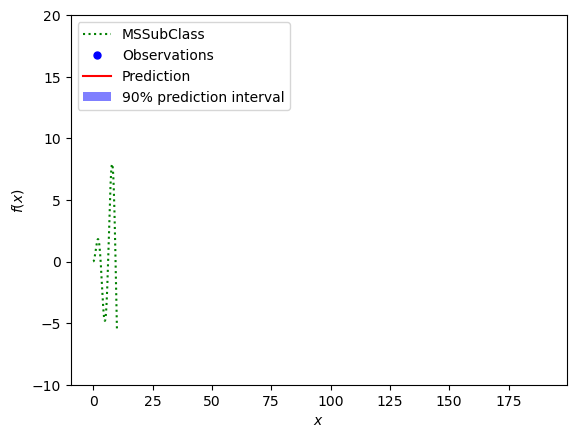

In [18]:
# TODO: FIX THIS
# Make the prediction on the meshed x-axis
tmp = learner.predict(xx)
y_lower, y_pred, y_upper = tmp[:, 0], tmp[:, 1], tmp[:, 2]

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label='MSSubClass')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')
plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

In [19]:
values_to_predict = np.unique(X).reshape(15, 1).astype(np.float32)
values_to_predict.shape
tmp = learner.predict(values_to_predict)
#tmp

In [20]:
tmp

array([[ 89992.19 , 167885.58 , 345240.88 ],
       [ 89588.47 , 167011.56 , 342244.75 ],
       [ 89184.766, 166137.56 , 339248.66 ],
       [ 88982.91 , 165700.56 , 337750.6  ],
       [ 88781.05 , 165263.55 , 336252.5  ],
       [ 88377.34 , 164389.53 , 333256.4  ],
       [ 87973.63 , 163515.5  , 330260.28 ],
       [ 87771.78 , 163078.52 , 328762.22 ],
       [ 87569.92 , 162641.52 , 327264.16 ],
       [ 87368.07 , 162204.48 , 325766.1  ],
       [ 87166.22 , 161767.48 , 324268.03 ],
       [ 85955.08 , 159145.44 , 315279.66 ],
       [ 84340.25 , 155649.4  , 303295.16 ],
       [ 83532.82 , 153901.36 , 297302.9  ],
       [ 83129.11 , 153027.36 , 294306.78 ]], dtype=float32)

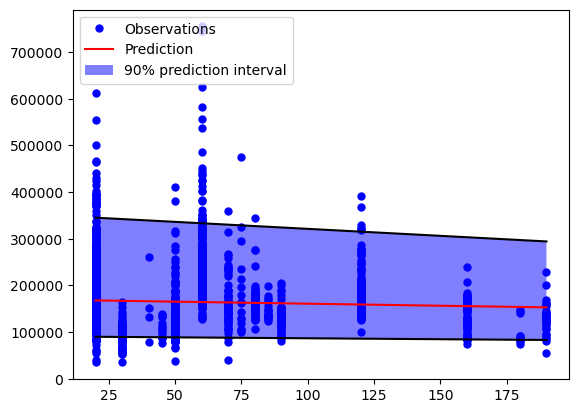

In [21]:
y_lower, y_pred, y_upper = tmp[:, 0], tmp[:, 1], tmp[:, 2]

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
#plt.plot(xx, f(xx), 'g:', label='MSSubClass')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(values_to_predict, y_pred, 'r-', label=u'Prediction')
plt.plot(values_to_predict, y_upper, 'k-')
plt.plot(values_to_predict, y_lower, 'k-')
plt.fill(np.concatenate([values_to_predict, values_to_predict[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
#plt.xlabel('$x$')
#plt.ylabel('$f(x)$')
#plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

Extend the new data to new dimension